In [1]:
import os
import numpy as np
import pandas as pd

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, 
                             f1_score, roc_auc_score, mean_squared_error)
from scipy.stats import ks_2samp

In [3]:
import os
import numpy as np
import pandas as pd

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, 
                             f1_score, roc_auc_score, mean_squared_error)
from scipy.stats import ks_2samp

# Caminho dos arquivos de cada fold
scaled_data_folder = "scaled_data"
target_col = "Churn"

# Função para calcular a estatística KS (Kolmogorov-Smirnov)
def kolmogorov_smirnov(y_true, y_prob):
    y_bin = np.array(y_true)
    pos_probs = y_prob[y_bin == 1]
    neg_probs = y_prob[y_bin == 0]
    ks_stat, p_value = ks_2samp(pos_probs, neg_probs)
    return ks_stat, p_value

# Função para avaliar métricas (Val ou Test)
def evaluate_metrics(y_true, y_prob, threshold=0.5):
    y_bin = np.array(y_true)
    y_pred = (y_prob >= threshold).astype(int)

    cm = confusion_matrix(y_bin, y_pred)
    precision = precision_score(y_bin, y_pred)
    recall    = recall_score(y_bin, y_pred)
    f1        = f1_score(y_bin, y_pred)
    auc = roc_auc_score(y_bin, y_prob)
    mse = mean_squared_error(y_bin, y_prob)
    ks_stat, ks_p = kolmogorov_smirnov(y_true, y_prob)

    return {
        "cm": cm,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
        "mse": mse,
        "ks_stat": ks_stat,
        "ks_p": ks_p
    }

# Loop para rodar nos 3 folds
all_fold_results = []
n_folds = 3

for i in range(n_folds):
    print(f"\n===== FOLD {i+1} =====")
    
    # Carregar CSVs para treino, validação e teste
    train_path = os.path.join(scaled_data_folder, f"train_fold_{i+1}_scaled.csv")
    val_path   = os.path.join(scaled_data_folder, f"val_fold_{i+1}_scaled.csv")
    test_path  = os.path.join(scaled_data_folder, f"test_fold_{i+1}_scaled.csv")
    
    train_df = pd.read_csv(train_path)
    val_df   = pd.read_csv(val_path)
    test_df  = pd.read_csv(test_path)
    
    # Separar X e y (Treino)
    X_train = train_df.drop(columns=[target_col])
    y_train = np.where(train_df[target_col] == 'Yes', 1, 0)  # Converter para 0/1

    # Separar X e y (Validação e Teste)
    X_val = val_df.drop(columns=[target_col])
    y_val = np.where(val_df[target_col] == 'Yes', 1, 0)  # Converter para 0/1

    X_test = test_df.drop(columns=[target_col])
    y_test = np.where(test_df[target_col] == 'Yes', 1, 0)  # Converter para 0/1

    # Construir pipeline com Oversampling + MLP
    pipeline = Pipeline([
        ('oversampler', RandomOverSampler(random_state=42)),
        ('mlp', MLPClassifier(max_iter=1000, random_state=42))
    ])

    # Definir hiperparâmetros para GridSearchCV
    param_grid = {
        'mlp__hidden_layer_sizes': [(50,), (50,50)],
        'mlp__activation': ['relu', 'tanh'],
        'mlp__learning_rate_init': [0.001, 0.01],
        'mlp__alpha': [0.0001, 0.001]
    }

    # Rodar GridSearchCV no subset de treinamento
    grid = GridSearchCV(
        pipeline,
        param_grid,
        scoring='f1',  # Agora funciona corretamente
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    # Melhor modelo encontrado
    best_model = grid.best_estimator_
    print("Melhores parâmetros encontrados:", grid.best_params_)
    print("Melhor pontuação de F1 (treino interno):", grid.best_score_)

    # Avaliar no conjunto de VALIDAÇÃO
    y_val_probs = best_model.predict_proba(X_val)[:, 1]
    val_metrics = evaluate_metrics(y_val, y_val_probs)

    # Avaliar no conjunto de TESTE
    y_test_probs = best_model.predict_proba(X_test)[:, 1]
    test_metrics = evaluate_metrics(y_test, y_test_probs)

    # Exibir métricas
    print("\n-- Métricas de Validação --")
    print(f"Confusion Matrix (Val):\n{val_metrics['cm']}")
    print(f"Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f} | F1: {val_metrics['f1']:.4f}")
    print(f"AUC: {val_metrics['auc']:.4f} | MSE: {val_metrics['mse']:.4f} | KS: {val_metrics['ks_stat']:.4f} (p={val_metrics['ks_p']:.4f})")

    print("\n-- Métricas de Teste --")
    print(f"Confusion Matrix (Test):\n{test_metrics['cm']}")
    print(f"Precision: {test_metrics['precision']:.4f} | Recall: {test_metrics['recall']:.4f} | F1: {test_metrics['f1']:.4f}")
    print(f"AUC: {test_metrics['auc']:.4f} | MSE: {test_metrics['mse']:.4f} | KS: {test_metrics['ks_stat']:.4f} (p={test_metrics['ks_p']:.4f})")

    # Guardar para estatísticas finais
    all_fold_results.append({
        "fold": i+1,
        "best_params": grid.best_params_,
        "val_metrics": val_metrics,
        "test_metrics": test_metrics
    })

# Calcular médias das métricas no TESTE entre os folds
f1_test_all  = [r["test_metrics"]["f1"]  for r in all_fold_results]
auc_test_all = [r["test_metrics"]["auc"] for r in all_fold_results]
mse_test_all = [r["test_metrics"]["mse"] for r in all_fold_results]
ks_test_all  = [r["test_metrics"]["ks_stat"] for r in all_fold_results]

print("\n=== RESULTADOS FINAIS (MÉDIA ± DESVIO) NO TESTE ===")
print(f"F1  = {np.mean(f1_test_all):.4f} ± {np.std(f1_test_all):.4f}")
print(f"AUC = {np.mean(auc_test_all):.4f} ± {np.std(auc_test_all):.4f}")
print(f"MSE = {np.mean(mse_test_all):.4f} ± {np.std(mse_test_all):.4f}")
print(f"KS  = {np.mean(ks_test_all):.4f} ± {np.std(ks_test_all):.4f}")


===== FOLD 1 =====
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Melhores parâmetros encontrados: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__learning_rate_init': 0.01}
Melhor pontuação de F1 (treino interno): 0.5552089854854159

-- Métricas de Validação --
Confusion Matrix (Val):
[[1472  235]
 [ 308  330]]
Precision: 0.5841 | Recall: 0.5172 | F1: 0.5486
AUC: 0.7736 | MSE: 0.2124 | KS: 0.4487 (p=0.0000)

-- Métricas de Teste --
Confusion Matrix (Test):
[[1503  248]
 [ 315  280]]
Precision: 0.5303 | Recall: 0.4706 | F1: 0.4987
AUC: 0.7529 | MSE: 0.2137 | KS: 0.3951 (p=0.0000)

===== FOLD 2 =====
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Melhores parâmetros encontrados: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,), 'mlp__learning_rate_init': 0.001}
Melhor pontuação de F1 (treino interno): 0.5371343206690578

-- Métricas de Validação --
Confusion Matrix (Val):
[[1427  

2025-03-10 12:49:28.902543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741621769.374071  328876 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741621769.488156  328876 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 12:49:30.881057: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



===== FOLD 1 =====
Treinando com {'hidden_units': (64, 32), 'dropout_rate': 0.3, 'learning_rate': 0.001}


2025-03-10 12:49:42.446420: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Treinando com {'hidden_units': (128, 64), 'dropout_rate': 0.4, 'learning_rate': 0.001}
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Treinando com {'hidden_units': (64, 32), 'dropout_rate': 0.2, 'learning_rate': 0.0005}
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Melhor configuração no Fold 1: {'hidden_units': (64, 32), 'dropout_rate': 0.2, 'learning_rate': 0.0005}
F1 (Val) = 0.6293
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

-- Métricas de Teste --
Confusion Matrix (Test):
[[1347  404]
 [ 173  422]]
Precision: 0.5109 | Recall: 0.7092 | F1: 0.5939
AUC: 0.8243 | MSE: 0.1615 | KS: 0.4911 (p=0.0000)


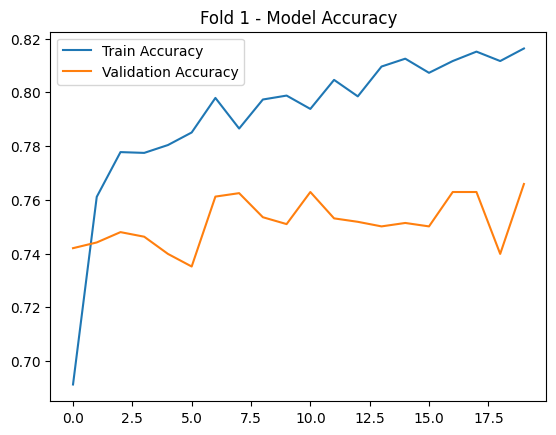

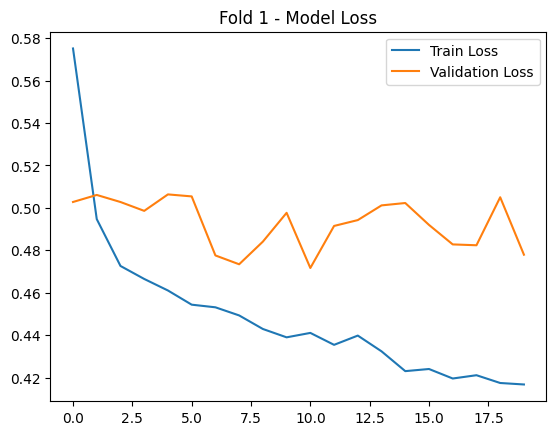


===== FOLD 2 =====
Treinando com {'hidden_units': (64, 32), 'dropout_rate': 0.3, 'learning_rate': 0.001}
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Treinando com {'hidden_units': (128, 64), 'dropout_rate': 0.4, 'learning_rate': 0.001}
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Treinando com {'hidden_units': (64, 32), 'dropout_rate': 0.2, 'learning_rate': 0.0005}
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Melhor configuração no Fold 2: {'hidden_units': (64, 32), 'dropout_rate': 0.2, 'learning_rate': 0.0005}
F1 (Val) = 0.5878
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

-- Métricas de Teste --
Confusion Matrix (Test):
[[1264  448]
 [ 136  498]]
Precision: 0.5264 | Recall: 0.7855 | F1: 0.6304
AUC: 0.8446 | MSE: 0.1643 | KS: 0.5330 (p=0.0000)


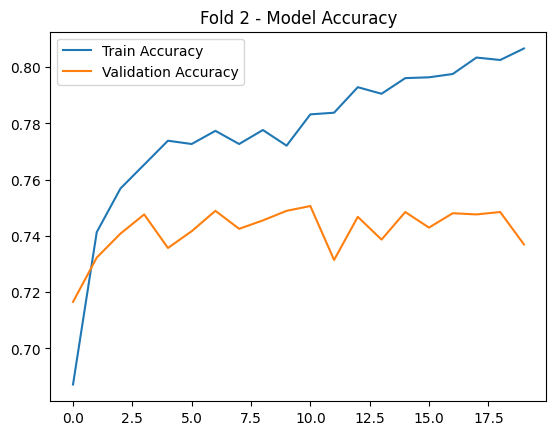

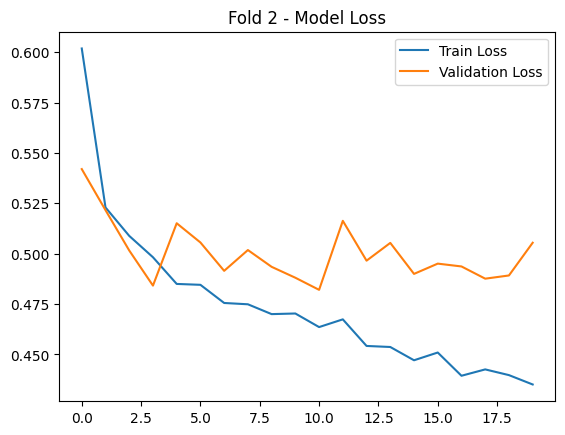


===== FOLD 3 =====
Treinando com {'hidden_units': (64, 32), 'dropout_rate': 0.3, 'learning_rate': 0.001}
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Treinando com {'hidden_units': (128, 64), 'dropout_rate': 0.4, 'learning_rate': 0.001}
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Treinando com {'hidden_units': (64, 32), 'dropout_rate': 0.2, 'learning_rate': 0.0005}
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Melhor configuração no Fold 3: {'hidden_units': (64, 32), 'dropout_rate': 0.2, 'learning_rate': 0.0005}
F1 (Val) = 0.6311
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

-- Métricas de Teste --
Confusion Matrix (Test):
[[1198  509]
 [ 143  495]]
Precision: 0.4930 | Recall: 0.7759 | F1: 0.6029
AUC: 0.8217 | MSE: 0.1771 | KS: 0.4938 (p=0.0000)


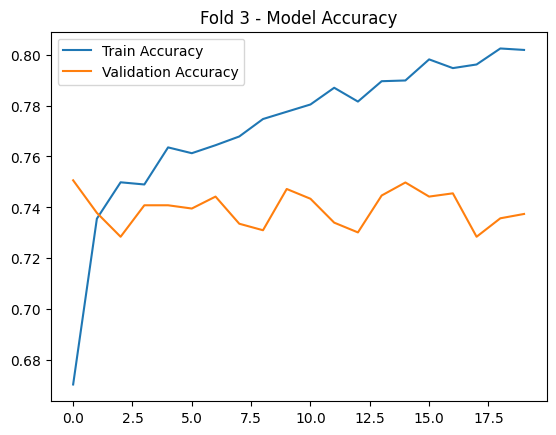

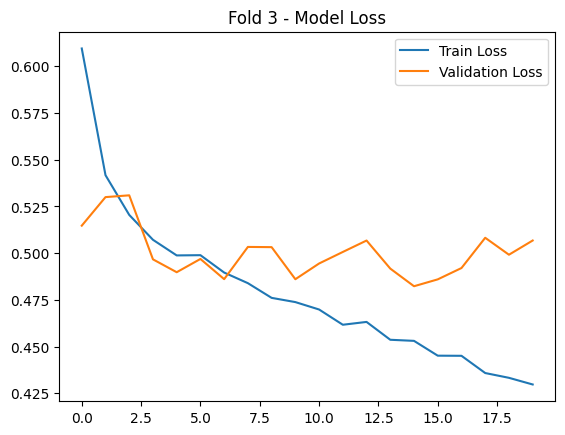

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
from scipy.stats import ks_2samp
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Caminho dos arquivos de cada fold
scaled_data_folder = "scaled_data"
target_col = "Churn"

# Função para calcular KS (Kolmogorov-Smirnov)
def kolmogorov_smirnov(y_true, y_prob):
    y_bin = np.array(y_true)
    pos_probs = y_prob[y_bin == 1]
    neg_probs = y_prob[y_bin == 0]
    ks_stat, p_value = ks_2samp(pos_probs, neg_probs)
    return ks_stat, p_value

# Função para avaliar métricas
def evaluate_metrics(y_true, y_prob, threshold=0.5):
    y_bin = np.array(y_true)
    y_pred = (y_prob >= threshold).astype(int)

    cm = confusion_matrix(y_bin, y_pred)
    precision = precision_score(y_bin, y_pred)
    recall    = recall_score(y_bin, y_pred)
    f1        = f1_score(y_bin, y_pred)
    auc = roc_auc_score(y_bin, y_prob)
    mse = mean_squared_error(y_bin, y_prob)
    ks_stat, ks_p = kolmogorov_smirnov(y_true, y_prob)

    return {
        "cm": cm,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
        "mse": mse,
        "ks_stat": ks_stat,
        "ks_p": ks_p
    }

# Função para criar modelo MLP com hiperparâmetros configuráveis
def build_mlp(input_dim, hidden_units=(64, 32), dropout_rate=0.3, learning_rate=0.001):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(hidden_units[0], activation='relu'),
        Dropout(dropout_rate),
        Dense(hidden_units[1], activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')  # Saída binária
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Loop para rodar nos 3 folds
all_fold_results = []
n_folds = 3

for i in range(n_folds):
    print(f"\n===== FOLD {i+1} =====")
    
    # Carregar CSVs para treino, validação e teste
    train_path = os.path.join(scaled_data_folder, f"train_fold_{i+1}_scaled.csv")
    val_path   = os.path.join(scaled_data_folder, f"val_fold_{i+1}_scaled.csv")
    test_path  = os.path.join(scaled_data_folder, f"test_fold_{i+1}_scaled.csv")
    
    train_df = pd.read_csv(train_path)
    val_df   = pd.read_csv(val_path)
    test_df  = pd.read_csv(test_path)
    
    # Separar X e y (Treino)
    X_train = train_df.drop(columns=[target_col]).values
    y_train = np.where(train_df[target_col] == 'Yes', 1, 0)  # Converter para 0/1

    # Separar X e y (Validação e Teste)
    X_val = val_df.drop(columns=[target_col]).values
    y_val = np.where(val_df[target_col] == 'Yes', 1, 0)  # Converter para 0/1

    X_test = test_df.drop(columns=[target_col]).values
    y_test = np.where(test_df[target_col] == 'Yes', 1, 0)  # Converter para 0/1

    # Oversampling no conjunto de treinamento
    ros = RandomOverSampler(random_state=42)
    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    # Definição de hiperparâmetros para grid search manual
    param_grid = [
        {"hidden_units": (64, 32), "dropout_rate": 0.3, "learning_rate": 0.001},
        {"hidden_units": (128, 64), "dropout_rate": 0.4, "learning_rate": 0.001},
        {"hidden_units": (64, 32), "dropout_rate": 0.2, "learning_rate": 0.0005},
    ]

    best_model = None
    best_f1_val = 0
    best_params = None
    best_history = None

    for params in param_grid:
        print(f"Treinando com {params}")

        # Criar modelo com os hiperparâmetros
        model = build_mlp(X_train.shape[1], 
                          hidden_units=params["hidden_units"], 
                          dropout_rate=params["dropout_rate"], 
                          learning_rate=params["learning_rate"])

        # Treinar modelo
        history = model.fit(X_train_res, y_train_res, 
                            validation_data=(X_val, y_val),
                            epochs=20, batch_size=32, verbose=0)

        # Avaliar no conjunto de validação
        y_val_probs = model.predict(X_val).flatten()
        val_metrics = evaluate_metrics(y_val, y_val_probs)

        # Salvar melhor modelo baseado no F1 de Validação
        if val_metrics["f1"] > best_f1_val:
            best_f1_val = val_metrics["f1"]
            best_model = model
            best_params = params
            best_history = history

    print(f"\nMelhor configuração no Fold {i+1}: {best_params}")
    print(f"F1 (Val) = {best_f1_val:.4f}")

    # Avaliar no conjunto de TESTE
    y_test_probs = best_model.predict(X_test).flatten()
    test_metrics = evaluate_metrics(y_test, y_test_probs)

    print("\n-- Métricas de Teste --")
    print(f"Confusion Matrix (Test):\n{test_metrics['cm']}")
    print(f"Precision: {test_metrics['precision']:.4f} | Recall: {test_metrics['recall']:.4f} | F1: {test_metrics['f1']:.4f}")
    print(f"AUC: {test_metrics['auc']:.4f} | MSE: {test_metrics['mse']:.4f} | KS: {test_metrics['ks_stat']:.4f} (p={test_metrics['ks_p']:.4f})")

    # Plotando curvas de treinamento
    plt.plot(best_history.history['accuracy'], label='Train Accuracy')
    plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f"Fold {i+1} - Model Accuracy")
    plt.show()

    plt.plot(best_history.history['loss'], label='Train Loss')
    plt.plot(best_history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f"Fold {i+1} - Model Loss")
    plt.show()

    all_fold_results.append(test_metrics)

In [6]:
import os
import numpy as np
import pandas as pd

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                             recall_score, f1_score, roc_auc_score, mean_squared_error)
from scipy.stats import ks_2samp

# Caminho dos arquivos de cada fold
scaled_data_folder = "scaled_data"
target_col = "Churn"

# Função para calcular Kolmogorov-Smirnov (KS)
def kolmogorov_smirnov(y_true, y_prob):
    y_bin = np.array(y_true)
    pos_probs = y_prob[y_bin == 1]
    neg_probs = y_prob[y_bin == 0]
    ks_stat, p_value = ks_2samp(pos_probs, neg_probs)
    return ks_stat, p_value

# Função para avaliar métricas
def evaluate_metrics(y_true, y_prob, threshold=0.5):
    y_bin = np.array(y_true)
    y_pred = (y_prob >= threshold).astype(int)

    cm = confusion_matrix(y_bin, y_pred)
    accuracy = accuracy_score(y_bin, y_pred)
    precision = precision_score(y_bin, y_pred)
    recall = recall_score(y_bin, y_pred)
    f1 = f1_score(y_bin, y_pred)
    auc = roc_auc_score(y_bin, y_prob)
    mse = mean_squared_error(y_bin, y_prob)
    ks_stat, ks_p = kolmogorov_smirnov(y_true, y_prob)

    return {
        "cm": cm,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
        "mse": mse,
        "ks_stat": ks_stat,
        "ks_p": ks_p
    }

# Loop para rodar nos 3 folds
all_fold_results = []
n_folds = 3

for i in range(n_folds):
    print(f"\n===== FOLD {i+1} =====")
    
    # Carregar CSVs para treino, validação e teste
    train_path = os.path.join(scaled_data_folder, f"train_fold_{i+1}_scaled.csv")
    val_path   = os.path.join(scaled_data_folder, f"val_fold_{i+1}_scaled.csv")
    test_path  = os.path.join(scaled_data_folder, f"test_fold_{i+1}_scaled.csv")
    
    train_df = pd.read_csv(train_path)
    val_df   = pd.read_csv(val_path)
    test_df  = pd.read_csv(test_path)
    
    # Separar X e y (Treino)
    X_train = train_df.drop(columns=[target_col])
    y_train = np.where(train_df[target_col] == 'Yes', 1, 0)  # Converter para 0/1

    # Separar X e y (Validação e Teste)
    X_val = val_df.drop(columns=[target_col])
    y_val = np.where(val_df[target_col] == 'Yes', 1, 0)  # Converter para 0/1

    X_test = test_df.drop(columns=[target_col])
    y_test = np.where(test_df[target_col] == 'Yes', 1, 0)  # Converter para 0/1

    # Construir pipeline com Oversampling + MLP
    pipeline = Pipeline([
        ('oversampler', RandomOverSampler(random_state=42)),
        ('mlp', MLPClassifier(max_iter=1000, random_state=42))
    ])

    # Definir hiperparâmetros para GridSearchCV
    param_grid = {
        'mlp__hidden_layer_sizes': [(50,), (50,50)],
        'mlp__activation': ['relu', 'tanh'],
        'mlp__learning_rate_init': [0.001, 0.01],
        'mlp__alpha': [0.0001, 0.001]
    }

    # Rodar GridSearchCV no subset de treinamento
    grid = GridSearchCV(
        pipeline,
        param_grid,
        scoring='f1',  # Otimizamos para F1, mas calculamos acurácia depois
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    # Melhor modelo encontrado
    best_model = grid.best_estimator_
    print("Melhores parâmetros encontrados:", grid.best_params_)
    print("Melhor pontuação de F1 (treino interno):", grid.best_score_)

    # Avaliar no conjunto de VALIDAÇÃO
    y_val_probs = best_model.predict_proba(X_val)[:, 1]
    val_metrics = evaluate_metrics(y_val, y_val_probs)

    # Avaliar no conjunto de TESTE
    y_test_probs = best_model.predict_proba(X_test)[:, 1]
    test_metrics = evaluate_metrics(y_test, y_test_probs)

    # Exibir métricas (agora com Acurácia)
    print("\n-- Métricas de Validação --")
    print(f"Confusion Matrix (Val):\n{val_metrics['cm']}")
    print(f"Accuracy: {val_metrics['accuracy']:.4f} | Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f} | F1: {val_metrics['f1']:.4f}")
    print(f"AUC: {val_metrics['auc']:.4f} | MSE: {val_metrics['mse']:.4f} | KS: {val_metrics['ks_stat']:.4f} (p={val_metrics['ks_p']:.4f})")

    print("\n-- Métricas de Teste --")
    print(f"Confusion Matrix (Test):\n{test_metrics['cm']}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f} | Precision: {test_metrics['precision']:.4f} | Recall: {test_metrics['recall']:.4f} | F1: {test_metrics['f1']:.4f}")
    print(f"AUC: {test_metrics['auc']:.4f} | MSE: {test_metrics['mse']:.4f} | KS: {test_metrics['ks_stat']:.4f} (p={test_metrics['ks_p']:.4f})")

    # Guardar para estatísticas finais
    all_fold_results.append({
        "fold": i+1,
        "best_params": grid.best_params_,
        "val_metrics": val_metrics,
        "test_metrics": test_metrics
    })

# Calcular médias das métricas no TESTE entre os folds
accuracy_test_all = [r["test_metrics"]["accuracy"] for r in all_fold_results]
f1_test_all  = [r["test_metrics"]["f1"]  for r in all_fold_results]
auc_test_all = [r["test_metrics"]["auc"] for r in all_fold_results]
mse_test_all = [r["test_metrics"]["mse"] for r in all_fold_results]
ks_test_all  = [r["test_metrics"]["ks_stat"] for r in all_fold_results]

print("\n=== RESULTADOS FINAIS (MÉDIA ± DESVIO) NO TESTE ===")
print(f"Accuracy = {np.mean(accuracy_test_all):.4f} ± {np.std(accuracy_test_all):.4f}")
print(f"F1       = {np.mean(f1_test_all):.4f} ± {np.std(f1_test_all):.4f}")
print(f"AUC      = {np.mean(auc_test_all):.4f} ± {np.std(auc_test_all):.4f}")
print(f"MSE      = {np.mean(mse_test_all):.4f} ± {np.std(mse_test_all):.4f}")
print(f"KS       = {np.mean(ks_test_all):.4f} ± {np.std(ks_test_all):.4f}")



===== FOLD 1 =====
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Melhores parâmetros encontrados: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__learning_rate_init': 0.01}
Melhor pontuação de F1 (treino interno): 0.5552089854854159

-- Métricas de Validação --
Confusion Matrix (Val):
[[1472  235]
 [ 308  330]]
Accuracy: 0.7684 | Precision: 0.5841 | Recall: 0.5172 | F1: 0.5486
AUC: 0.7736 | MSE: 0.2124 | KS: 0.4487 (p=0.0000)

-- Métricas de Teste --
Confusion Matrix (Test):
[[1503  248]
 [ 315  280]]
Accuracy: 0.7600 | Precision: 0.5303 | Recall: 0.4706 | F1: 0.4987
AUC: 0.7529 | MSE: 0.2137 | KS: 0.3951 (p=0.0000)

===== FOLD 2 =====
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Melhores parâmetros encontrados: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,), 'mlp__learning_rate_init': 0.001}
Melhor pontuação de F1 (treino interno): 0.5371343206690578

-- Métricas de Validaç